# Setup TinyBERT

Este notebook utiliza o TinyBERT, uma versão compacta e eficiente do modelo BERT. O TinyBERT foi projetado para ser menor e mais rápido, sem perder muito em termos de precisão e desempenho. A versão do modelo utilizada neste trabalho é a TinyBERT_General_4L_312D, desenvolvida pela Huawei. Esse modelo é pré-treinado e otimizado para ser eficiente tanto em termos de espaço quanto de tempo de computação, mantendo um desempenho competitivo para diversas tarefas de Processamento de Linguagem Natural (PLN). Referências para o código e mais detalhes podem ser encontradas na documentação desse projeto.

## Baixar os pacotes

In [ ]:
!pip install datasets transformers accelerate -q

: 

## Treino da Rede Neural

A partir daqui, inicializaremos a construção da rede neural utilizando o TinyBERT. Redes neurais são amplamente utilizadas em diversas tarefas de aprendizado de máquina, incluindo reconhecimento de padrões, visão computacional e PLN - que é o contexto desse projeto.

### 1. Bibliotecas Necessárias

In [2]:
import torch
from datasets import load_dataset, Dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


### 2. Preparação do Dataset

In [3]:
# Carregando o dataset
df = pd.read_csv("../data/processed_classification-labeled.csv")
# Ajustando a coluna 'sentiment' para que 0 e 1 sejam considerados não-negativos (0) e -1 permaneça como negativo (1)
df['label'] = df['sentiment'].apply(lambda x: 0 if x in [0, 1] else 1)

# Transformando o DataFrame em um Dataset do HuggingFace
dataset = Dataset.from_pandas(df)

# Dividindo o dataset em treinamento e validação
train_test_dataset = dataset.train_test_split(test_size=0.2)
train_dataset = train_test_dataset['train']
valid_dataset = train_test_dataset['test']


### 3. Tokenização

In [ ]:
model_checkpoint = "huawei-noah/TinyBERT_General_4L_312D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(examples['pos_tokens'], padding="max_length", truncation=True)

train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)


### 4. Carregamento do Modelo e Definição de Métricas

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2).to(device)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average=None, labels=[0, 1])
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1_negativos': f1[1],
        'f1_nao_negativos': f1[0],
        'recall_negativos': recall[1],
        'recall_nao_negativos': recall[0],
        'precision_negativos': precision[1],
        'precision_nao_negativos': precision[0]
    }


### 5. Configuração e Treinamento do Modelo

In [6]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Negativos,F1 Nao Negativos,Recall Negativos,Recall Nao Negativos,Precision Negativos,Precision Nao Negativos
1,No log,0.425986,0.805556,0.861386,0.674419,0.878788,0.644444,0.844660,0.707317
2,0.458600,0.398737,0.815972,0.865482,0.708791,0.861111,0.716667,0.869898,0.701087


TrainOutput(global_step=576, training_loss=0.4469796352916294, metrics={'train_runtime': 468.4217, 'train_samples_per_second': 9.82, 'train_steps_per_second': 1.23, 'total_flos': 13455467605104.0, 'train_loss': 0.4469796352916294, 'epoch': 2.0})

In [ ]:
# @article{jiao2019tinybert,
# title={Tinybert: Distilling bert for natural language understanding},
# uthor={Jiao, Xiaoqi and Yin, Yichun and Shang, Lifeng and Jiang, Xin and Chen, Xiao and Li, Linlin and Wang, Fang and Liu, Qun},
# journal={arXiv preprint arXiv:1909.10351},
 # year={2019}



O modelo TinyBERT foi treinado em duas épocas e obteve as seguintes métricas de desempenho: Loss de Treinamento, Loss de Validação, Acurácia, F1 Negativos, F1 Não Negativos, Recall Negativos, Recall Não Negativos, Precisão Negativos e Precisão Não Negativos. O modelo apresentou uma melhoria geral nas métricas ao longo de duas épocas de treinamento. O Loss de Validação diminuiu de 0.425986 para 0.398737, indicando melhor capacidade de generalização. A acurácia aumentou ligeiramente de 0.805556 para 0.815972, enquanto o F1-Score para a classe dos negativos subiu de 0.861386 para 0.865482 e para a classe dos não negativos aumentou significativamente de 0.674419 para 0.708791, refletindo uma melhor previsão dessa classe. O recall dos negativos diminuiu levemente de 0.878788 para 0.861111, mas para os não negativos aumentou de 0.644444 para 0.716667. A precisão dos negativos melhorou de 0.844660 para 0.869898, enquanto a dos não negativos caiu levemente de 0.707317 para 0.701087. Em conclusão, o modelo demonstra um progresso positivo, apesar de um pequeno trade-off entre recall e precisão.

### 6. Avaliação e Vizualização dos Resultados

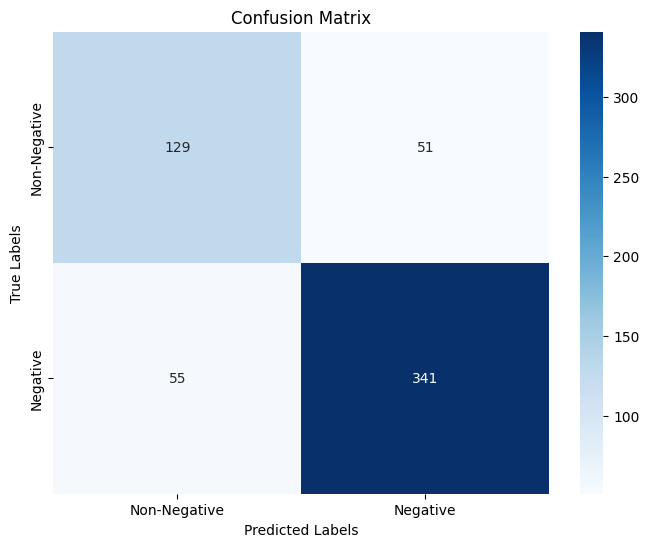

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
predictions = trainer.predict(valid_dataset)
pred_labels = np.argmax(predictions.predictions, axis=1)

# Matriz de Confusão
cm = confusion_matrix(predictions.label_ids, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Negative", "Negative"], yticklabels=["Non-Negative", "Negative"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

A matriz de confusão mostra que o modelo TinyBERT classificou corretamente 341 exemplos negativos e 129 não negativos, com 55 falsos negativos e 51 falsos positivos. Isso confirma as métricas discutidas, como o aumento no recall dos não negativos, que passou de 0.644444 para 0.716667, e a ligeira queda no recall dos negativos de 0.878788 para 0.861111. A precisão dos negativos aumentou de 0.844660 para 0.869898, enquanto a dos não negativos caiu levemente de 0.707317 para 0.701087. A matriz evidencia a melhora geral do modelo na classificação, apesar do pequeno trade-off entre recall e precisão.

O TinyBERT supera os modelos Bag of Words (BoW) com Naive Bayes e Regressão Logística, que mostraram limitações na classificação precisa de sentimentos, com acurácias de apenas 0.7066 e 0.7448, respectivamente. Além disso, embora o Word2Vec com Random Forest tenha alcançado uma alta acurácia de 0.98, testes adicionais revelaram problemas de overfitting, comprometendo a viabilidade desses resultados para aplicações práticas. Portanto, o TinyBERT se destaca por sua consistência em comparação com esses modelos.